In [1]:
import pandas as pd
from calitp_data_analysis.tables import tbls
from siuba import _, collect, count, filter, show_query
from update_vars import GCS_FILE_PATH


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Additional Transit Performance Metrics #899

Use the newer recommendations which include performance metrics and ridership experience as outlined in the [UCLA Options for the Future of State Funding for Transit Operations in California](https://escholarship.org/uc/item/2zb6z5rm).  Should try and run/describe all outlined.


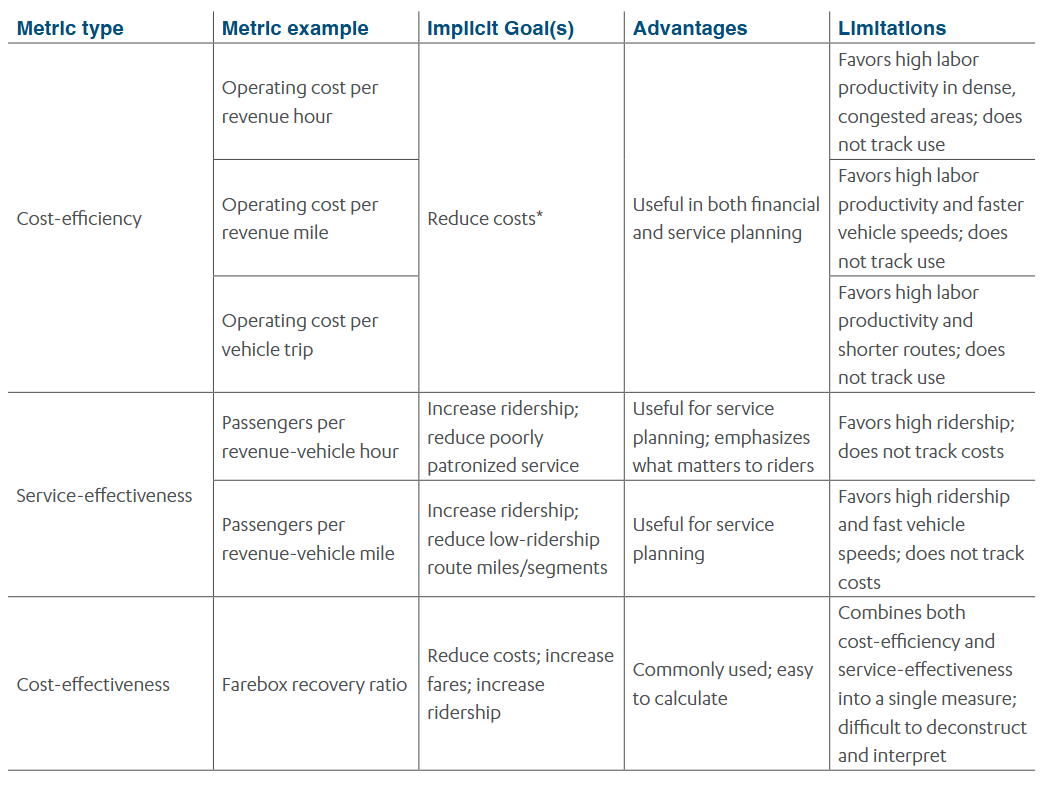

## Data Sources

NTD Products
- [2023 Annual Database Operating Expenses](https://www.transit.dot.gov/ntd/data-product/2023-annual-database-operating-expenses)
    - data url: "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Operating%20Expenses.xlsx"
- [2022 Annual Database Operating Expenses](https://www.transit.dot.gov/ntd/data-product/2022-annual-database-operating-expenses)
    - data url: "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-04/2022%20Operating%20Expenses.xlsx"

Warehose Tables
- <s>`dim_monthly_ridership_with_adjustments `</s>, but is only for Monthly reporters
- `dim_annual_service_agencies`, has all type of reporters, VRM, VRH, UPT

## Metrics to calculate

Cost-efficiency metrics
- Operating cost per VRH
- Operating cost per VRM
- Operating cost per trip(?)

Service-effectiveness metrics
- Passengers (upt?) per VRH
- Passengers per VRM

---

## Get `operating cost` for CA reporters

In [49]:
# read in dim_annual_service_agencies, filter for reporters in CA for 2023

annnual_service_agencies = (
    tbls.mart_ntd.dim_annual_service_agencies() 
    >> filter(_.state == "CA",
              _.report_year == 2023
             )
    >> collect()
)
#annnual_service_agencies.info() # 209 rows

In [18]:
ca_ntd_ids = annnual_service_agencies["ntd_id"].unique() # unique ntd ID to filter by

display(
    type(ca_ntd_ids),
    len(ca_ntd_ids),
)

numpy.ndarray

209

'90008'

In [23]:
# Read in 2023 NTD operating exp data
ntd_2023_opex = "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Operating%20Expenses.xlsx"

col_dict={'NTD ID':str}
opex_2023 = pd.read_excel(
    ntd_2023_opex, 
    dtype = (col_dict)
)


Confirmed with the [data.transportation.gov interface](https://data.transportation.gov/Public-Transit/2022-2023-NTD-Annual-Data-Operating-Expenses-by-Ty/j5uj-anzx/explore/query/SELECT%0A%20%20%60agency%60%2C%0A%20%20%60city%60%2C%0A%20%20%60state%60%2C%0A%20%20%60ntd_id%60%2C%0A%20%20%60organization_type%60%2C%0A%20%20%60reporter_type%60%2C%0A%20%20%60report_year%60%2C%0A%20%20%60uace_code%60%2C%0A%20%20%60uza_name%60%2C%0A%20%20%60primary_uza_population%60%2C%0A%20%20%60agency_voms%60%2C%0A%20%20%60mode%60%2C%0A%20%20%60mode_name%60%2C%0A%20%20%60type_of_service%60%2C%0A%20%20%60mode_voms%60%2C%0A%20%20%60operators_wages%60%2C%0A%20%20%60operators_wages_questionable%60%2C%0A%20%20%60other_salaries_wages%60%2C%0A%20%20%60other_salaries_wages_1%60%2C%0A%20%20%60operator_paid_absences%60%2C%0A%20%20%60operator_paid_absences_1%60%2C%0A%20%20%60other_paid_absences%60%2C%0A%20%20%60other_paid_absences_1%60%2C%0A%20%20%60fringe_benefits%60%2C%0A%20%20%60fringe_benefits_questionable%60%2C%0A%20%20%60services%60%2C%0A%20%20%60services_questionable%60%2C%0A%20%20%60fuel_and_lube%60%2C%0A%20%20%60fuel_and_lube_questionable%60%2C%0A%20%20%60tires%60%2C%0A%20%20%60tires_questionable%60%2C%0A%20%20%60other_materials_supplies%60%2C%0A%20%20%60other_materials_supplies_1%60%2C%0A%20%20%60utilities%60%2C%0A%20%20%60utilities_questionable%60%2C%0A%20%20%60casualty_and_liability%60%2C%0A%20%20%60casualty_and_liability_1%60%2C%0A%20%20%60taxes%60%2C%0A%20%20%60taxes_questionable%60%2C%0A%20%20%60purchased_transportation%60%2C%0A%20%20%60purchased_transportation_1%60%2C%0A%20%20%60miscellaneous%60%2C%0A%20%20%60miscellaneous_questionable%60%2C%0A%20%20%60reduced_reporter_expenses%60%2C%0A%20%20%60reduced_reporter_expenses_1%60%2C%0A%20%20%60total%60%2C%0A%20%20%60total_questionable%60%2C%0A%20%20%60separate_report_amount%60%2C%0A%20%20%60separate_report_amount_1%60%0AWHERE%0A%20%20caseless_one_of%28%60report_year%60%2C%20%222023%22%29%0A%20%20AND%20%28caseless_one_of%28%60state%60%2C%20%22CA%22%29%0A%20%20%20%20%20%20%20%20%20AND%20caseless_one_of%28%0A%20%20%20%20%20%20%20%20%20%20%20%60agency%60%2C%0A%20%20%20%20%20%20%20%20%20%20%20%22Sacramento%20Regional%20Transit%20District%2C%20dba%3A%20Sacramento%20RT%22%0A%20%20%20%20%20%20%20%20%20%29%29/page/filter) to use `total operating expense type = "Total" `

In [48]:
keep_cols = [
    "NTD ID",
    "Agency Name",
    "Reporter Type",
    "Operating Expense Type", 
    "Total Operating Expenses",
    "Total Operating Expenses (No Funds Reported Separately)" 
]

ca_opex_2023 = opex_2023[
    opex_2023["NTD ID"].isin(ca_ntd_ids)
][keep_cols] #1250 rows

ca_opex_2023 = ca_opex_2023[ca_opex_2023["Operating Expense Type"] == "Total"] #426 rows

ca_opex_agg = ca_opex_2023.groupby(["NTD ID","Agency Name"]).agg({
    "Total Operating Expenses":"sum"
}).reset_index()

display(
    ca_opex_2023["NTD ID"].nunique(),#209, matches unique ntd ids list
    ca_opex_2023.info(),
    ca_opex_agg # LA County has multiple NTD IDs?
)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 7590 to 9059
Data columns (total 6 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   NTD ID                                                   426 non-null    object
 1   Agency Name                                              426 non-null    object
 2   Reporter Type                                            426 non-null    object
 3   Operating Expense Type                                   426 non-null    object
 4   Total Operating Expenses                                 426 non-null    int64 
 5   Total Operating Expenses (No Funds Reported Separately)  426 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 23.3+ KB


209

None

,NTD ID,Agency Name,Total Operating Expenses
0,90003,San Francisco Bay Area Rapid Transit District,796259977
1,90004,Golden Empire Transit District,36554386
2,90006,Santa Cruz Metropolitan Transit District,48569321
3,90008,City of Santa Monica,80777272
4,90009,San Mateo County Transit District,192548133
5,90010,City of Torrance,25569435
6,90012,San Joaquin Regional Transit District,42349184
7,90013,Santa Clara Valley Transportation Authority,454070971
8,90014,Alameda-Contra Costa Transit District,532406680
9,90015,City and County of San Francisco,974494589


In [56]:
print(len(annnual_service_agencies))
keep_cols_2 = [
    "key",
    "report_year",
    "ntd_id",
    "agency",
    "reporter_type",
    "organization_type",
    "actual_vehicles_passenger_car_revenue_hours",
    "actual_vehicles_passenger_car_revenue_miles",
    "unlinked_passenger_trips_upt",
    "Total Operating Expenses"
]

ca_service_agency_opex = annnual_service_agencies.merge(
    ca_opex_agg,
    how="inner", 
    left_on="ntd_id", 
    right_on="NTD ID"
)[keep_cols_2]

print(ca_service_agency_opex.info())

209
<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   key                                          209 non-null    object 
 1   report_year                                  209 non-null    int64  
 2   ntd_id                                       209 non-null    object 
 3   agency                                       209 non-null    object 
 4   reporter_type                                209 non-null    object 
 5   organization_type                            209 non-null    object 
 6   actual_vehicles_passenger_car_revenue_hours  209 non-null    float64
 7   actual_vehicles_passenger_car_revenue_miles  209 non-null    float64
 8   unlinked_passenger_trips_upt                 209 non-null    float64
 9   Total Operating Expenses                     209 non-null    int64  
dty

In [57]:
ca_service_agency_opex

,key,report_year,ntd_id,agency,reporter_type,organization_type,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles,unlinked_passenger_trips_upt,Total Operating Expenses
0,2f7175b9aedfff555e30f030e2e45b75,2023,90003,"San Francisco Bay Area Rapid Transit District,...",Full Reporter,Independent Public Agency or Authority of Tran...,2724074.0,85233749.0,50764402.0,796259977
1,342c66110a6c5cbfef065608b53b009a,2023,90004,Golden Empire Transit District,Full Reporter,Independent Public Agency or Authority of Tran...,289338.0,3924016.0,3293593.0,36554386
2,231d30a033adffad7c05ad22cdffc83a,2023,90006,Santa Cruz Metropolitan Transit District,Full Reporter,Independent Public Agency or Authority of Tran...,214748.0,2975126.0,3350026.0,48569321
3,bb4a900bf5c07c09e8211b7ee1f8502b,2023,90008,"City of Santa Monica, dba: Big Blue Bus",Full Reporter,"City, County or Local Government Unit or Depar...",416944.0,3920395.0,7767725.0,80777272
4,c66136eb07990c683307924891da05a5,2023,90009,"San Mateo County Transit District, dba: SamTrans",Full Reporter,Independent Public Agency or Authority of Tran...,651839.0,7793698.0,8773845.0,192548133
5,4362f7cb24acbc33a3d27edd3ed20c77,2023,90010,"City of Torrance, dba: Torrance Transit System",Full Reporter,"City, County or Local Government Unit or Depar...",103526.0,1402852.0,1840079.0,25569435
6,b54cef7138d0057e9085da47db94506e,2023,90012,"San Joaquin Regional Transit District, dba: Sa...",Full Reporter,Independent Public Agency or Authority of Tran...,197664.0,2612286.0,2301789.0,42349184
7,91df0abfcbd3472d38a4224067582dc3,2023,90013,"Santa Clara Valley Transportation Authority, d...",Full Reporter,Independent Public Agency or Authority of Tran...,1733169.0,21779295.0,23853939.0,454070971
8,2a9e17b7701a70a0ab6087f589d20c95,2023,90014,"Alameda-Contra Costa Transit District, dba: AC...",Full Reporter,Independent Public Agency or Authority of Tran...,2047682.0,22350644.0,35190057.0,532406680
9,9419a1a0a9ed3d5152066d7404b73fed,2023,90015,"City and County of San Francisco, dba: San Fra...",Full Reporter,"City, County or Local Government Unit or Depar...",3302230.0,24205877.0,139127693.0,974494589
